In [40]:
import os
import glob
import json
from matplotlib import pyplot as plt
import numpy as np

In [41]:
indiv_stations  = ['US001N']
all_stations = False

dates = ['20230805']

# Just for this example on '20230805'
confirmed_flight_ids_with_contrails = ['3C6514_DLH413']

In [42]:
# Find all flights that have been extracted
flight_dirs = []

for date in dates:
    if all_stations:
        station_dirs = glob('../data/gmn_extracted_flight_images/*/')
        stations = []
        for station_dir in station_dirs:
            station_name = os.path.basename(os.path.normpath(station_dir))
            if os.path.isdir(os.path.join(station_dir, date)):
                stations.append(station_name)
            else:
                print(f'Could not find {station_name} for {date}, skipping')
    else:
        stations = indiv_stations

    for station in stations:
        curr_flight_dirs = [ f.path for f in os.scandir(f'../data/gmn_extracted_flight_images/{station}/{date}/') if f.is_dir() ]

        if len(curr_flight_dirs) > 0:
            if len(curr_flight_dirs) < 10:
                print(f'Warning: found fewer than 10 flights for {station} on {date}, it is likely that the camera calibration is faulty due to cloudy weather')
            flight_dirs += curr_flight_dirs
        else:
            print(f'Could not find find flights for {station} on {date}, skipping')

In [43]:
# Iterate through all flights and save the features extracted from the segmentation masks
ious = []
lengths = []
widths = []
total_areas = []
mask_in_bbox_percentage = []
temporal_variabilities = []

flight_ids = []
for flight_dir in flight_dirs:
    # Load json file in flight dir
    if os.path.exists(os.path.join(flight_dir, 'sam2_output', 'metadata.json')):
        with open(os.path.join(flight_dir, 'sam2_output', 'metadata.json')) as f:
            metadata = json.load(f)

    flight_id = os.path.basename(os.path.normpath(flight_dir))
    flight_ids.append(flight_id)
    ious.append(metadata['mask_features']['iou'])
    lengths.append(metadata['mask_features']['length'])
    widths.append(metadata['mask_features']['width'])
    total_areas.append(metadata['mask_features']['total_area'])
    mask_in_bbox_percentage.append(metadata['mask_features']['mask_in_bbox'])
    temporal_variabilities.append(metadata['mask_features']['temporal_variability'])

ious = np.array(ious)
lengths = np.array(lengths)
widths = np.array(widths)
length_width_ratio = lengths / widths
total_areas = np.array(total_areas)
mask_in_bbox_percentage = np.array(mask_in_bbox_percentage)
temporal_variabilities = np.array(temporal_variabilities)

C:\Users\Jacob\AppData\Local\Temp\ipykernel_23952\2680548399.py:28: RuntimeWarning: divide by zero encountered in divide
  length_width_ratio = lengths / widths


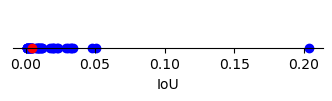

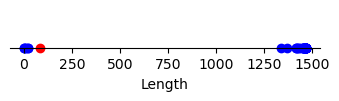

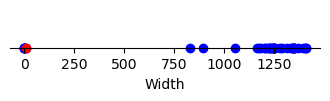

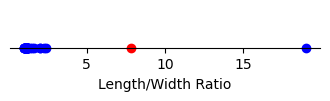

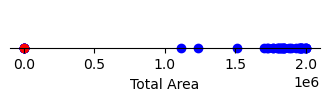

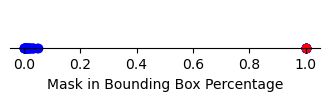

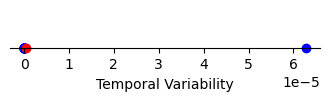

In [44]:
# Visualise the features as 1D scatter plots
def plot_1d_scatter(data, title, confirmed_contrail_indices, unconfirmed_contrail_indices):
    fig, ax = plt.subplots(1, 1, figsize=(4, 1))
    ax.scatter(data[unconfirmed_contrail_indices], [0] * len(unconfirmed_contrail_indices), c='b')
    ax.scatter(data[confirmed_contrail_indices], [0] * len(confirmed_contrail_indices), c='r')
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel(title)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    plt.show()
    
confirmed_contrail_indices = [i for i, flight_id in enumerate(flight_ids) if flight_id in confirmed_flight_ids_with_contrails]
unconfirmed_contrail_indices = [i for i, flight_id in enumerate(flight_ids) if flight_id not in confirmed_flight_ids_with_contrails]

plot_1d_scatter(ious, 'IoU', confirmed_contrail_indices, unconfirmed_contrail_indices)
plot_1d_scatter(lengths, 'Length', confirmed_contrail_indices, unconfirmed_contrail_indices)
plot_1d_scatter(widths, 'Width', confirmed_contrail_indices, unconfirmed_contrail_indices)
plot_1d_scatter(length_width_ratio, 'Length/Width Ratio', confirmed_contrail_indices, unconfirmed_contrail_indices)
plot_1d_scatter(total_areas, 'Total Area', confirmed_contrail_indices, unconfirmed_contrail_indices)
plot_1d_scatter(mask_in_bbox_percentage, 'Mask in Bounding Box Percentage', confirmed_contrail_indices, unconfirmed_contrail_indices)
plot_1d_scatter(temporal_variabilities, 'Temporal Variability', confirmed_contrail_indices, unconfirmed_contrail_indices)

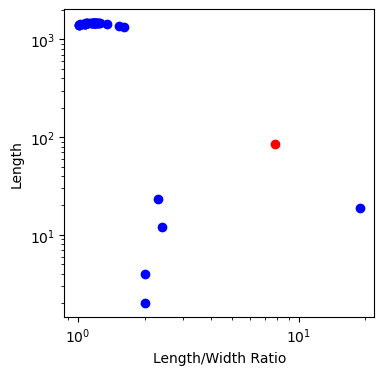

In [48]:
# Visualise in 2D how we could combine some features
def plot_2d_scatter(feat1, feat2, unconfirmed_contrail_indices, confirmed_contrail_indices):
    fig, axs = plt.subplots(1, 1, figsize=(4, 4))
    axs.scatter(feat1[0][unconfirmed_contrail_indices], feat2[0][unconfirmed_contrail_indices], c='b')
    axs.scatter(feat1[0][confirmed_contrail_indices], feat2[0][confirmed_contrail_indices], c='r')
    axs.set_xlabel(feat1[1])
    axs.set_ylabel(feat2[1])

    # Log scale
    axs.set_xscale('log')
    axs.set_yscale('log')
    
plot_2d_scatter((length_width_ratio, 'Length/Width Ratio'), (lengths, 'Length'), unconfirmed_contrail_indices, confirmed_contrail_indices)

# Print length width ratios sorted, together with their flight id
length_width_ratios_with_ids = list(zip(length_width_ratio, flight_ids))
length_width_ratios_with_ids.sort()
for length_width_ratio, flight_id in length_width_ratios_with_ids:
    print(f'{flight_id}: {length_width_ratio}')